In [2]:
import pandas as pd
import numpy as np
import os
import re

# # Set working directory
# if not "/data/tables" in os.getcwd():
#     os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/14 13:05:29 WARN Utils: Your hostname, Kes-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.243.118 instead (on interface en0)
22/09/14 13:05:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/14 13:05:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.9.7 (default, Sep 16 2021 08:50:36)
Spark context Web UI available at http://10.13.243.118:4043
Spark context available as 'sc' (master = local[*], app id = local-1663124730136).
SparkSession available as 'spark'.


In [2]:
sdf = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")

In [5]:
sdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [7]:
consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")

In [11]:
consumer_fraud_df.head(10)

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
5,16556,2022-02-20,89.656633
6,10278,2021-09-28,83.591367
7,15790,2021-12-30,71.770659
8,5233,2021-08-29,85.871233
9,230,2021-08-28,86.283288


In [58]:
#merchant_fraud_df.head(20)
merchant_fraud_df[merchant_fraud_df["merchant_abn"] == 19492220327]
merchant_fraud_df.shape[0]

114

22/09/12 17:12:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 293583 ms exceeds timeout 120000 ms
22/09/12 17:12:36 WARN SparkContext: Killing executors is not supported by current scheduler.


## Merchant Fraud
Check if there is missing data

In [47]:
merchant_sdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_sdf.printSchema()
merchant_df = merchant_sdf.toPandas()

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)



In [54]:
#merchant_sdf.select("merchant_abn").distinct().count()
# 4026 entries distince values of merchant

fraud_union = set(merchant_fraud_df["merchant_abn"].unique()) # 61 unique cases
all_union = set(merchant_df["merchant_abn"].unique())
len(all_union.intersection(fraud_union))



48

Only 48/4026 merchants have fraud data
13/61 of the fraud data cannot be matched with any merchant abn

Try merge the merchant fraud data with transactions on order date + abn ????

## Costumer Fraud

In [59]:
costumer_sdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
costumer_df = costumer_sdf.toPandas()
costumer_df.head()

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975


In [61]:
# costumer_sdf.distinct().count() # 499999 distinc values

499999

In [76]:
from pyspark.sql import functions as F
transaction_df1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_df2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_df3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_df1.union(transaction_df2).union(transaction_df3)

transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))
# lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0.001)
# iqr = upr - lwr
# lwr_bound = lwr - 1.5 * iqr
# upr_bound = upr + 1.5 * iqr
# lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

# new_transaction = transaction.where(
#     (F.col('dollar_value') >= lwr_bound) &
#     (F.col('dollar_value') <= upr_bound)
# )
merchant = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_abn = merchant.toPandas()['merchant_abn'].unique().tolist()
filtered_transaction = transaction.where(F.col('merchant_abn').isin(merchant_abn))
merchant_daily_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 


In [78]:
#merchant_daily_transaction.count() # 13584371

13584371

In [8]:
merchant_daily_transaction.head()

22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on

Row(merchant_abn=13839274306, order_datetime=datetime.date(2021, 8, 20), user_id=3968, no_order=1, dollar_amount=88.4084826726033)

In [9]:
merchant_daily_transaction.select(max ('no_order'))

# MAX order is 3 

max(no_order)
3


The granularity level of the analysis is day level.

In [77]:
# entry 5 has high fraud rate, investigate this instance
# 82999039227,2021-12-19
# 35575706403,2022-02-20 entrie 43 
# 97884414539,2021-10-19,89.79919971536573

import datetime
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 35575706403)
   & (F.col('order_datetime') == "2022-02-20")
)

# print(35575706403 in merchant_abn)


merchant_abn,order_datetime,user_id,no_order,dollar_amount


In [28]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
19492220327,2021-11-28,21706,1,1903.7191517251547


In [52]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
#    (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
    (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
27093785141,2021-08-19,21706,1,297.1060630006161
32656335530,2021-05-15,21706,1,45.95924058414554
14639489823,2022-05-10,21706,1,73.82891944981822
79269463423,2022-06-10,21706,1,192.44624685911833
46804135891,2021-11-12,21706,1,15.1040241409343
93561083066,2021-09-04,21706,1,71.9166019734691
86578477987,2022-06-27,21706,1,25.86363096512127
77013874702,2022-05-03,21706,1,3.684141987613139
92207241352,2021-08-22,21706,1,75.9671958496898
63465140133,2022-08-20,21706,1,8.25922769029275


0      250.808535
1      408.057444
2      438.018593
3      445.260618
4      481.082374
5      499.069962
6      500.028030
7      520.101543
8      569.764190
9      670.574100
10     690.432965
11     730.222732
12     735.933539
13     846.595621
14     889.726316
15    1111.031757
16    1118.301486
17    1218.987852
18    1237.045610
19    1239.207726
20    1341.267156
21    1361.404935
22    1404.574261
23    1413.346048
24    1422.707061
25    1456.190296
26    1478.473170
27    1506.509017
28    1510.705345
29    1521.193623
30    1529.736079
31    1540.472208
32    1557.832092
33    1562.109957
34    1573.383720
35    1592.294531
36    1621.683178
37    1649.083869
38    1651.775446
39    1658.561342
40    1660.545605
41    1775.652049
42    1809.076630
43    1817.478741
44    1833.847579
45    1834.585632
46    1850.165879
47    1859.957235
48    1873.931185
49    1902.846589
50    1903.719152
51    1937.971379
52    1980.996787
53    1984.709733
54    1991.984611
55    2032

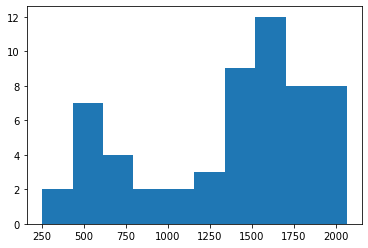

In [54]:
test_dollar_amout = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

import matplotlib.pyplot as plt



sorted = test_dollar_amout.sort_values(by="dollar_amount").reset_index()["dollar_amount"]
# plt.plot(sorted)
plt.hist(sorted) # mixure model?
# print(test_dollar_amout.mean())
# print(test_dollar_amout.std())
print(sorted)

# transaction level fraud detection
### idea 1 


fit a kmeans model to each merchant using ADK(automatic determination of Kmeans. granularity level is month since sku is unlikely to change too often), find std of each cluster, each cluster is seen as a normal distribution. 

When new transaction data come, first sort it to one cluster, then use quantile method of normal to determine the probability of it being a fraud.



### idea 2

Based on bayesian statistic. Fit a distribution (start with poisson) to every merchant. Use quantile method 


In [64]:
# user_id,order_datetime,fraud_probability
# 6228,2021-12-19,97.6298077657765 investigate this

merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   # &
   # (F.col('order_datetime') == datetime.date(2021, 12, 19))
 & (F.col('dollar_amount') <= 1279.315571)
& (F.col('dollar_amount') >= 1277.315571)

#    & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
81776569986,2021-03-03,6228,1,1278.315571140402


,dollar_amount
0,502.107659
1,1278.315571
2,62.893256
3,230.216561
4,84.566328
...,...
540,74.979890
541,75.176187
542,60.498921
543,75.781941


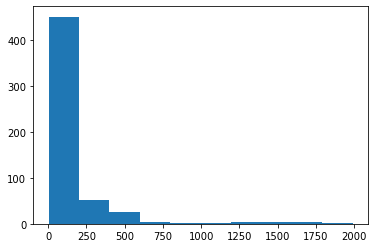

In [61]:
consumer = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
  
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    &
#    (F.col('order_datetime') == datetime.date(2021, 12, 19))
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

plt.hist(consumer["dollar_amount"]) 
consumer